<a href="https://colab.research.google.com/github/JonathanMartignon/DeepLearningIntroduction/blob/main/Tarea3_Marti%C3%B1%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 3: Transferencia de conocimiento y redes recurrentes
## Martiñón Luna Jonathan José
### Aprendizaje Profundo
### Semestre 2021-II

Resuelve los siguientes ejercicios en libretas de Colab independientes que sean replicables.

**Para hacer más sencillo, en cada punto se agregó la instrucción que necesitaba (De cualquier forma se puede verificar funcionamiento y precencia de los cambios). Este ejercicio está basado en la libreta 3b**

1. Entrena modelos de regresión para predecir edades en el conjunto de datos UTKFace. La solución debe cumplir con los siguientes puntos:

- Implementa la tubería de datos usando el conjunto de rostros alineados y recortados.
```
# Se cambió el archivo a descargar, se analizó su estructura y adaptó
# La extracción de las edades (Acorde a su etiquetado)
tvu.download_and_extract_archive(
            url='https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download',
            download_root=self.root,
            filename='UTKFace.tar.gz',
```
- Agrega acrecentamiento de datos usando un espejeo horizontal.
```
# Basados en la libreta 3a
T.RandomHorizontalFlip()
```
- Particiona aleatoriamente en subconjuntos entrenamiento 80 % y prueba 20 %.
```
# Se mantuvo el que ya existía
trn_size = int(0.8 * len(ds))
tst_size = len(ds) - trn_size
trn_ds, tst_ds = random_split(ds, [trn_size, tst_size])
```
- Usando transferencia de conocimiento, entrena un modelo reentrenando solo la  ́ultima capa.
```
# Dado que la última capa era nuestra regresión, congelamos los parámetros
for param in model.cnn.parameters():
    param.requires_grad = False
_ = model.eval()
# Y al entrenar y evaluar se utilizó únicamente la parte de la regresión
model.reg.train()
model.reg.eval()
```

*Había un error que hablaba sobre los tamaños al parecer envié un  torch.Size([32]) y requería de un torch.Size([32,1]). No entendí dónde modificarlo*

- Usando transferencia de conocimiento, entrena un modelo reentrenando toda la red.
```
# Dado que la última capa era nuestra regresión, congelamos los parámetros
for param in model.cnn.parameters():
    param.requires_grad = False
_ = model.eval()
# Y al entrenar y evaluar usamos todo
model.train()
model.eval()
```


- Discute el comportamiento de los modelos durante el entrenamiento y los resultados finales en ambos conjuntos.

*De la figura dónde se expresa el MSE, podemos observar que a lo largo de 10 épocas, el modelo que entrenó únicamente la parte de regresión, resulta con una mayor variación en la etapa de entrenamiento, mientras que resultó más constante para la parte de prueba.*

*Curiosamente la época 4 (Hablando de la época de entrenamiento del segundo modelo) tiene una gran variación (En comparación del rango de movimiento de las demás épocas).*

*Curiosamente a la época número 10 no existe una gran diferencia entre ambos casos, sin embargo, aparenta una tendencia a la baja el modelo entrenado completamente.*

*En el caso del R^2, podemos observar una diferencia bastante significativa para ambos modelos. Siendo nuevamente el modelo donde se entrenó la red completamente, aquél que seleccionaremos*

## 1 Preparación

### 1.1 Bibliotecas

In [1]:
# Colab
! pip install torchinfo

In [2]:
# funciones aleatorias
import random
# sistema de archivos
import os
# flush!
import sys
# procesamiento xml
import xml.etree.ElementTree as ET
# sistema de archivos
from os.path import join

# gráficas
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
import torchvision.models as tvm
import torchvision.transforms as T
from scipy.io import loadmat
from torch.utils.data import DataLoader, random_split
# from torchvision.datasets import VisionDataset 
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm import tqdm
# imágenes
from PIL import Image
from sklearn.metrics import  r2_score

### 1.2 Utilerias

In [3]:
# directorio de datos
DATA_DIR = './datos'

# tamaño del lote
BATCH_SIZE = 32
# tamaño de la imagen
IMG_SIZE = 224

# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# filas y columnas de la cuadrícula 
ROWS, COLS = 4, 8


def display_grid(rows, cols, xs, y_true, y_pred=None, 
                 y_true_color='b', y_pred_color='g', figsize=(14, 7)):
    """Despliega ejemplos en una cuadrícula."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            img = xs[i]
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            
            if y_pred is not None:
              ax[r, c].set_title(f"V={y_true[i]}  P={y_pred[i]}")
            else:
              ax[r, c].set_title(f"V={y_true[i]}")
              
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(rows, cols, x, y_true, y_pred=None, 
                  y_true_color='b', y_pred_color='g', figsize=(14, 7)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)

    y_true = y_true.numpy().astype(np.uint8)
    if y_pred is not None:
        y_pred = y_pred.numpy().astype(np.uint8)
    display_grid(rows, cols, x, y_true, y_pred, 
                 y_true_color=y_true_color,
                 y_pred_color=y_pred_color,
                 figsize=figsize)

def set_seed(seed=2209):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# reproducibilidad
set_seed()

In [4]:
#!rm -r ./datos

## 2 Datos

### 2.1 Conjunto de datos

In [5]:
# basado en https://github.com/pytorch/vision/blob/master/torchvision/datasets/caltech.py 
class UTKFace:

    def __init__(self, root, transform, download=False):
        self.root = join(root, 'UTKFace')
        self.images_dir = join(self.root, 'UTKFace')
        self.transform = transform
        os.makedirs(self.root, exist_ok=True)

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError(
                'Dataset not found or corrupted.' +
                ' You can use download=True to download it')

        # Recordamos que está codificado de la forma
        # [Edad]_[Género]_[race]_[Fecha&Hora].jpg
        # Dado que deseamos extraer la edad
        self.categories = sorted(os.listdir(self.images_dir))

        self.y = []
        for imagen in self.categories:
          # Listamos por el guión bajo y sabemos que el primero es la edad
          # Por algún extraño motivo, al hacer el append, lo agregaba como tuplas
          # (1,2,3,...) En lugar de listas, eso se soluciona al convertirlo a enteros
          self.y.append(int(imagen.split("_")[0]))

    def __getitem__(self, index):
      
        img = Image.open(join(
            self.images_dir,
            self.categories[index])
        )

        # si la imagen es escala de grises
        # transformamos a RGB
        if img.mode == 'L':
            rgbimg = Image.new('RGB', img.size)
            rgbimg.paste(img)
            img = rgbimg

        if self.transform is not None:
            img = self.transform(img)

        return img,self.y[index]

    def __len__(self):
        return len(self.categories)
    
    def _check_integrity(self):
        return os.path.exists(self.images_dir)

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        tvu.download_and_extract_archive(
            url='https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download',
            download_root=self.root,
            filename='UTKFace.tar.gz',
        )

### 2.2 Transformación

### 2.3 Instancia del conjunto y partición

In [6]:
# transofrmación de la imagen
img_tsfm = T.Compose([
    # redimensionamos a 224x224
    T.Resize([IMG_SIZE, IMG_SIZE]),
    # De 3a:
    # aumentado de datos
    # espejeo horizontal aleatorio
    T.RandomHorizontalFlip(),
    # convertimos a torch.Tensor [3,H,W]
    # y escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])


ds = UTKFace(DATA_DIR, img_tsfm, download=True)

trn_size = int(0.8 * len(ds))
tst_size = len(ds) - trn_size
trn_ds, tst_ds = random_split(ds, [trn_size, tst_size])
len(trn_ds), len(tst_ds)


Extracting ./datos/UTKFace/UTKFace.tar.gz to ./datos/UTKFace


(18966, 4742)

### 2.4 Cargadores de datos

In [7]:
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # 4 procesos paralelos
    num_workers=4
)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # 4 procesos paralelos
    num_workers=4
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.int64


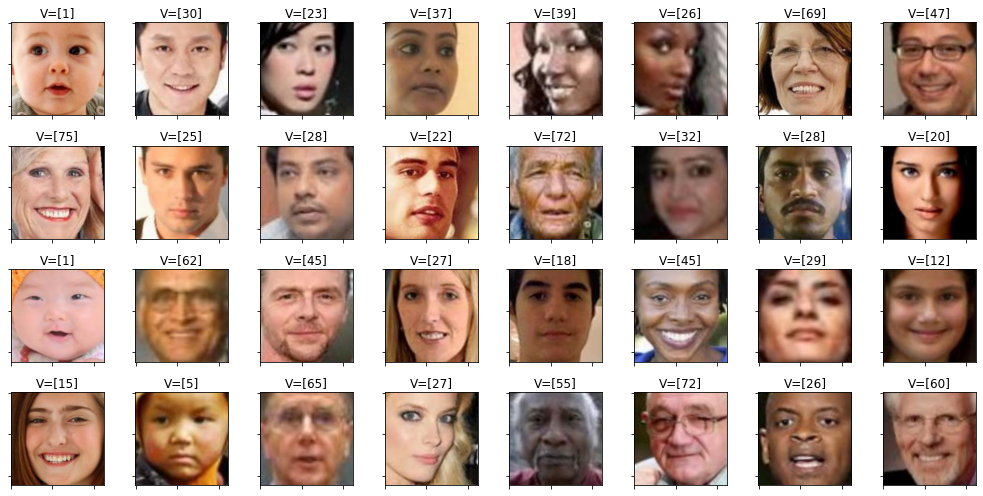

In [8]:
x, y = next(iter(trn_dl))
y = y.reshape(-1,1)
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(ROWS, COLS, x, y)

## 3 Modelo

Torchvision provee una familia de [modelos](https://pytorch.org/docs/1.6.0/torchvision/models.html#classification) preentrenados en ImageNet. Usaremos [Shufflenet V2](https://arxiv.org/abs/1807.11164), una arquitectura eficiente para clasificación de imágenes. 

In [9]:
tvm.shufflenet_v2_x0_5()

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

### 3.1 Carga de pesos y transferencia

In [10]:
class SimpleLocNet(nn.Module):
    
    def __init__(self, pretrained):
        super(SimpleLocNet, self).__init__()
        
        # cargamos el modelo
        self.cnn = tvm.shufflenet_v2_x0_5(pretrained=pretrained)
        # remplazamos la FC para dejar intactas 
        # las características (diablito)
        self.cnn.fc = nn.Identity()

        in_features = 1024
        # armamos la capa de regresión
        # En este caso sólo queremos 1 valor (La edad)
        self.reg = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, 1)
        )
    
    def forward(self, x):
        # [N, 3, 224, 224] => [N, 1024]
        x = self.cnn(x)
        # [N, 1024] => [N, 4]
        x = self.reg(x)
        return x
    
model = SimpleLocNet(True)

# congelado de parámetros de la CNN
for param in model.cnn.parameters():
    param.requires_grad = False
# congelado de estadísticas de todo el modelo
_ = model.eval()

Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


### 3.2 Inspección de la arquitectura

In [11]:
summary(model, (1, 3, IMG_SIZE, IMG_SIZE), device='cpu', verbose=0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                        Output Shape              Param #
SimpleLocNet                                  --                        --
├─ShuffleNetV2: 1-1                           [1, 1024]                 --
│    └─Sequential: 2-1                        [1, 24, 112, 112]         --
│    │    └─Conv2d: 3-1                       [1, 24, 112, 112]         (648)
│    │    └─BatchNorm2d: 3-2                  [1, 24, 112, 112]         (48)
│    │    └─ReLU: 3-3                         [1, 24, 112, 112]         --
│    └─MaxPool2d: 2-2                         [1, 24, 56, 56]           --
│    └─Sequential: 2-3                        [1, 48, 28, 28]           --
│    │    └─InvertedResidual: 3-4             [1, 48, 28, 28]           (2,400)
│    │    └─InvertedResidual: 3-5             [1, 48, 28, 28]           (1,512)
│    │    └─InvertedResidual: 3-6             [1, 48, 28, 28]           (1,512)
│    │    └─InvertedResidual: 3-7             [1, 48, 28, 28]           (1,

## 4 Entrenamiento

<!-- <img src="../figs/comida_entrenamiento.svg" width="650" height="450"> -->

In [12]:
!nvidia-smi

Sat Jun 19 18:10:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
# movemos el modelo 
model = model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

### 4.1 Ciclo de entrenamiento

In [15]:

def train_model(model, trn_dl, tst_dl,lr = 1e-2,EPOCHS = 10):
  # optimizador
  opt = optim.Adam(model.parameters(), lr=lr)

  mse_train,mse_test = [], []
  r2_train, r2_test = [], []
  for epoch in range(EPOCHS):
      
      # capas de regresión en modo de entrenamiento
      model.reg.train()
      
      # entrenamiento de una época
      for x, y_true in tqdm(trn_dl, desc=f'E{epoch:2d} Train'):
          
          mses, r2s = [], []

          y_true = y_true.reshape(-1,1)
          
          # movemos a dispositivo
          x = x.to(device)
          y_true = y_true.to(device)
          # computamos la predicción
          y_pred = model(x)
          # computamos la pérdida
          loss = F.mse_loss(y_pred, y_true.float())
          r2 = r2_score(y_true.cpu().detach().numpy(),y_pred.cpu().detach().numpy())
          # vaciamos los gradientes
          opt.zero_grad()
          # retropropagamos
          loss.backward()
          # actualizamos parámetros
          opt.step() 
          # guardamos históricos
          mses.append(loss.item())
          r2s.append(r2)     

      # Para la gráfica final
      mse_train.append(np.mean(mses))
      r2_train.append(np.mean(r2s))
      
      # imprimimos métricas
      print(f'\nE{epoch:2} TRAIN: mse={np.mean(mses):7.2f} r2={np.mean(r2s):4.2f}')
      
      # capas de regresión en modo de evaluación
      model.reg.eval()    
      
      # evitamos que se registren las operaciones 
      # en la gráfica de cómputo
      with torch.no_grad():
          
          mses, r2s = [], []
          # validación de la época
          for x, y_true in tqdm(tst_dl, desc=f'E{epoch:2d} Test '):
              # movemos a dispositivo
              x = x.to(device)
              y_true = y_true.reshape(-1,1)
              y_true = y_true.to(device)
              # computamos la predicción
              y_pred = model(x)
              # computamos la pérdida
              mse = F.mse_loss(y_pred, y_true)
              # computamos la IOU
              r2 = r2_score(y_true.cpu().numpy(),y_pred.cpu().numpy())
              # guardamos históricos
              mses.append(mse.item())
              r2s.append(r2)

          # promediamos métricas
          mse = np.mean(mses)
          r2 = np.mean(r2s)

          # Para la gráfica final
          mse_test.append(mse)
          r2_test.append(r2)

          # imprimimos métricas
          print(f'\nE{epoch:2} TEST: mse={mse:7.2f} r2={r2:4.2f}')
      
  sys.stdout.flush()

  return mse_train,r2_train,mse_test,r2_test, model

In [16]:
mse_train,r2_train,mse_test,r2_test, model = train_model(model, trn_dl, tst_dl)

E 0 Train:   0%|          | 0/593 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 0 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 0 TRAIN: mse= 109.21 r2=0.76


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 1 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 0 TEST: mse= 129.02 r2=0.64


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 1 Test :   0%|          | 0/149 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



E 1 TRAIN: mse= 137.44 r2=0.63


E 2 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 1 TEST: mse= 130.72 r2=0.63


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 2 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 2 TRAIN: mse= 139.79 r2=0.72


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 3 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 2 TEST: mse= 123.32 r2=0.65


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 3 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 3 TRAIN: mse=  87.03 r2=0.74


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 4 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 3 TEST: mse= 120.93 r2=0.66


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 4 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 4 TRAIN: mse= 162.54 r2=0.68


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 5 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 4 TEST: mse= 121.11 r2=0.66


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 5 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 5 TRAIN: mse= 197.82 r2=0.51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 6 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 5 TEST: mse= 130.82 r2=0.63


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 6 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 6 TRAIN: mse=  83.63 r2=0.69


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 7 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 6 TEST: mse= 119.58 r2=0.67


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 7 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 7 TRAIN: mse= 164.25 r2=0.48


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 8 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 7 TEST: mse= 118.29 r2=0.67


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 8 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 8 TRAIN: mse= 164.41 r2=0.61


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 9 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 8 TEST: mse= 121.78 r2=0.66


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 9 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 9 TRAIN: mse= 108.21 r2=0.64


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 9 Test : 100%|██████████| 149/149 [00:11<00:00, 12.94it/s]


E 9 TEST: mse= 126.89 r2=0.64


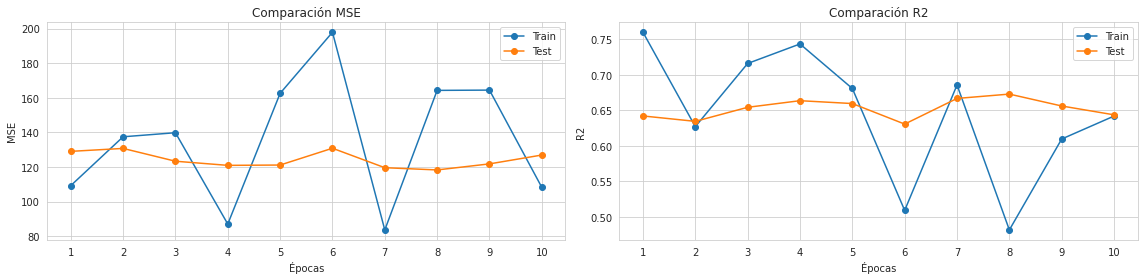

In [17]:
sns.set_style("whitegrid")
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(mse_train,marker="o")
plt.plot(mse_test,marker="o")
plt.legend(["Train","Test"])
plt.title("Comparación MSE")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.xticks(np.arange(0,len(mse_train)),np.arange(1,len(mse_train)+1))

plt.subplot(1,2,2)
plt.plot(r2_train,marker="o")
plt.plot(r2_test,marker="o")
plt.legend(["Train","Test"])
plt.title("Comparación R2")
plt.xlabel("Épocas")
plt.ylabel("R2")
plt.xticks(np.arange(0,len(r2_train)),np.arange(1,len(r2_train)+1))


plt.tight_layout()
plt.show()

## Entrenando la red completa

In [18]:
# Generamos nuestro modelo sin preentrenamiento
# Y tampoco congelamos parámetros ni estadísticas    
model2 = SimpleLocNet(False)

In [19]:
summary(model2, (1, 3, IMG_SIZE, IMG_SIZE), device='cpu', verbose=0)

Layer (type:depth-idx)                        Output Shape              Param #
SimpleLocNet                                  --                        --
├─ShuffleNetV2: 1-1                           [1, 1024]                 --
│    └─Sequential: 2-1                        [1, 24, 112, 112]         --
│    │    └─Conv2d: 3-1                       [1, 24, 112, 112]         648
│    │    └─BatchNorm2d: 3-2                  [1, 24, 112, 112]         48
│    │    └─ReLU: 3-3                         [1, 24, 112, 112]         --
│    └─MaxPool2d: 2-2                         [1, 24, 56, 56]           --
│    └─Sequential: 2-3                        [1, 48, 28, 28]           --
│    │    └─InvertedResidual: 3-4             [1, 48, 28, 28]           2,400
│    │    └─InvertedResidual: 3-5             [1, 48, 28, 28]           1,512
│    │    └─InvertedResidual: 3-6             [1, 48, 28, 28]           1,512
│    │    └─InvertedResidual: 3-7             [1, 48, 28, 28]           1,512
│    └─

In [20]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [21]:
# movemos el modelo 
model2 = model2.to(device)
next(model2.parameters()).device

device(type='cuda', index=0)

In [22]:
# Modificamos la función a que entrene y evalúe
# ya no sólo con la capa de regresión

def train_model2(model, trn_dl, tst_dl,lr = 1e-2,EPOCHS = 10):
  # optimizador
  opt = optim.Adam(model.parameters(), lr=lr)

  mse_train,mse_test = [], []
  r2_train, r2_test = [], []
  for epoch in range(EPOCHS):
      
      # capas en modo de entrenamiento
      model.train()
      
      # entrenamiento de una época
      for x, y_true in tqdm(trn_dl, desc=f'E{epoch:2d} Train'):
          mses, r2s = [], []

          # movemos a dispositivo
          x = x.to(device)
          y_true = y_true.reshape(-1,1)
          y_true = y_true.to(device)
          # computamos la predicción
          y_pred = model(x)
          # computamos la pérdida
          loss = F.mse_loss(y_pred, y_true.float())
          r2 = r2_score(y_true.cpu().detach().numpy(),y_pred.cpu().detach().numpy())
          # vaciamos los gradientes
          opt.zero_grad()
          # retropropagamos
          loss.backward()
          # actualizamos parámetros
          opt.step() 
          # guardamos históricos
          mses.append(loss.item())
          r2s.append(r2)     

      # Para la gráfica final
      mse_train.append(np.mean(mses))
      r2_train.append(np.mean(r2s))
      
      # imprimimos métricas
      print(f'\nE{epoch:2} TRAIN: mse={np.mean(mses):7.2f} r2={np.mean(r2s):4.2f}')
      
      # capas en modo de evaluación
      model.eval()    
      
      # evitamos que se registren las operaciones 
      # en la gráfica de cómputo
      with torch.no_grad():
          
          mses, r2s = [], []
          # validación de la época
          for x, y_true in tqdm(tst_dl, desc=f'E{epoch:2d} Test '):
              # movemos a dispositivo
              x = x.to(device)
              y_true = y_true.reshape(-1,1)
              y_true = y_true.to(device)
              # computamos la predicción
              y_pred = model(x)
              # computamos la pérdida
              mse = F.mse_loss(y_pred, y_true)
              # computamos la IOU
              r2 = r2_score(y_true.cpu().numpy(),y_pred.cpu().numpy())
              # guardamos históricos
              mses.append(mse.item())
              r2s.append(r2)

          # promediamos métricas
          mse = np.mean(mses)
          r2 = np.mean(r2s)

          # Para la gráfica final
          mse_test.append(mse)
          r2_test.append(r2)

          # imprimimos métricas
          print(f'\nE{epoch:2} TEST: mse={mse:7.2f} r2={r2:4.2f}')
      
  sys.stdout.flush()

  return mse_train,r2_train,mse_test,r2_test, model

In [23]:
mse_train2,r2_train2,mse_test2,r2_test2, model2 = train_model2(model2, trn_dl, tst_dl)

E 0 Train:   0%|          | 0/593 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 0 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 0 TRAIN: mse= 178.85 r2=0.50


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 1 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 0 TEST: mse= 193.86 r2=0.47


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 1 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 1 TRAIN: mse= 107.43 r2=0.75


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 2 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 1 TEST: mse= 152.55 r2=0.58


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 2 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 2 TRAIN: mse= 144.72 r2=0.75


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 3 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 2 TEST: mse= 111.88 r2=0.70


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 3 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 3 TRAIN: mse= 309.02 r2=0.35


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 4 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 3 TEST: mse= 131.71 r2=0.64


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 4 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 4 TRAIN: mse=  84.08 r2=0.80


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 5 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 4 TEST: mse= 161.43 r2=0.53


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 5 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 5 TRAIN: mse=  98.28 r2=0.55


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 6 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 5 TEST: mse= 117.01 r2=0.66


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 6 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 6 TRAIN: mse= 161.02 r2=0.37


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 7 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 6 TEST: mse=  97.69 r2=0.73


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 7 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 7 TRAIN: mse=  40.50 r2=0.81


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 8 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 7 TEST: mse= 123.09 r2=0.67


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 8 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 8 TRAIN: mse=  83.98 r2=0.80


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 9 Train:   0%|          | 0/593 [00:00<?, ?it/s]


E 8 TEST: mse=  88.52 r2=0.75


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 9 Test :   0%|          | 0/149 [00:00<?, ?it/s]


E 9 TRAIN: mse=  90.52 r2=0.74


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
E 9 Test : 100%|██████████| 149/149 [00:11<00:00, 12.95it/s]


E 9 TEST: mse=  78.58 r2=0.78


# Comparamos rendimientos

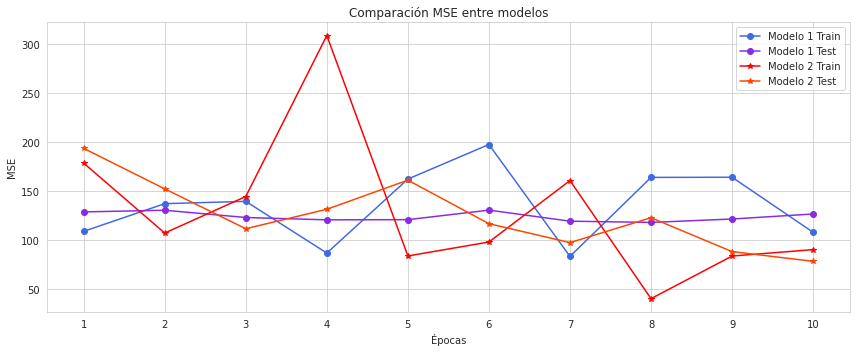

In [24]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,5))

plt.plot(mse_train,marker="o", color = "royalblue", label = "Modelo 1 Train")
plt.plot(mse_test,marker="o", color = "blueviolet" , label="Modelo 1 Test")
plt.plot(mse_train2,marker="*", color = "red" ,label= "Modelo 2 Train")
plt.plot(mse_test2,marker="*", color = "orangered", label = "Modelo 2 Test")

plt.legend()
plt.title("Comparación MSE entre modelos")
plt.xlabel("Épocas")
plt.ylabel("MSE")

plt.xticks(np.arange(0,len(mse_train)),np.arange(1,len(mse_train)+1))
plt.tight_layout()
plt.show()

De la figura anterior, podemos observar que a lo largo de 10 épocas, el modelo que entrenó únicamente la parte de regresión, resulta con una mayor variación en la etapa de entrenamiento, mientras que resultó más constante para la parte de prueba.

Curiosamente la época 4 (Hablando de la época de entrenamiento del segundo modelo) tiene una gran variación (En comparación del rango de movimiento de las demás épocas).

Curiosamente a la época número 10 no existe una gran diferencia entre ambos casos, sin embargo, aparenta una tendencia a la baja el modelo entrenado completamente.

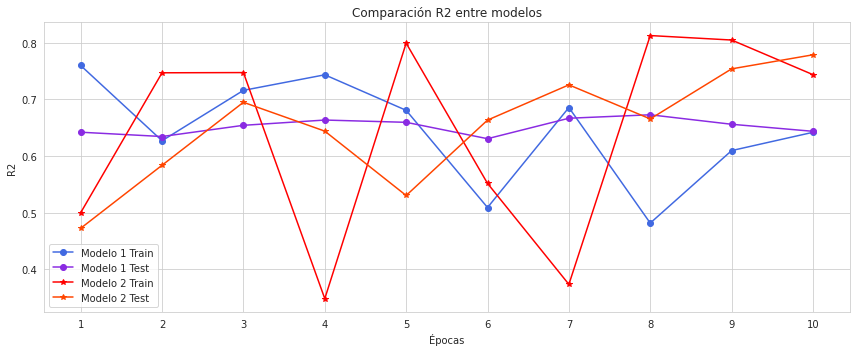

In [25]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,5))

plt.plot(r2_train,marker="o", color = "royalblue", label = "Modelo 1 Train")
plt.plot(r2_test,marker="o", color = "blueviolet", label = "Modelo 1 Test")
plt.plot(r2_train2,marker="*", color = "red", label = "Modelo 2 Train")
plt.plot(r2_test2,marker="*", color = "orangered", label = "Modelo 2 Test")
plt.legend()
plt.title("Comparación R2 entre modelos")
plt.xlabel("Épocas")
plt.ylabel("R2")
plt.xticks(np.arange(0,len(r2_train)),np.arange(1,len(r2_train)+1))
plt.tight_layout()
plt.show()

En el caso de esta figura, podemos observar una diferencia bastante significativa para ambos modelos. Siendo nuevamente el modelo donde se entrenó la red completamente, aquél que seleccionaremos

### 5.2 Evaluando en prueba

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


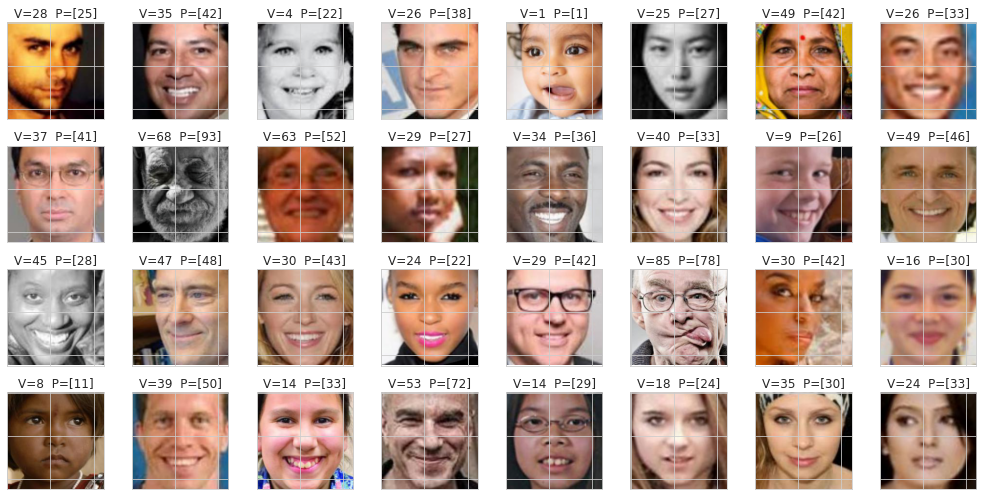

In [26]:
with torch.no_grad():
    x, y_true = next(iter(tst_dl))
    y_pred = model(x.to(device))
    display_batch(ROWS, COLS, x.cpu(), y_true, y_pred.cpu())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


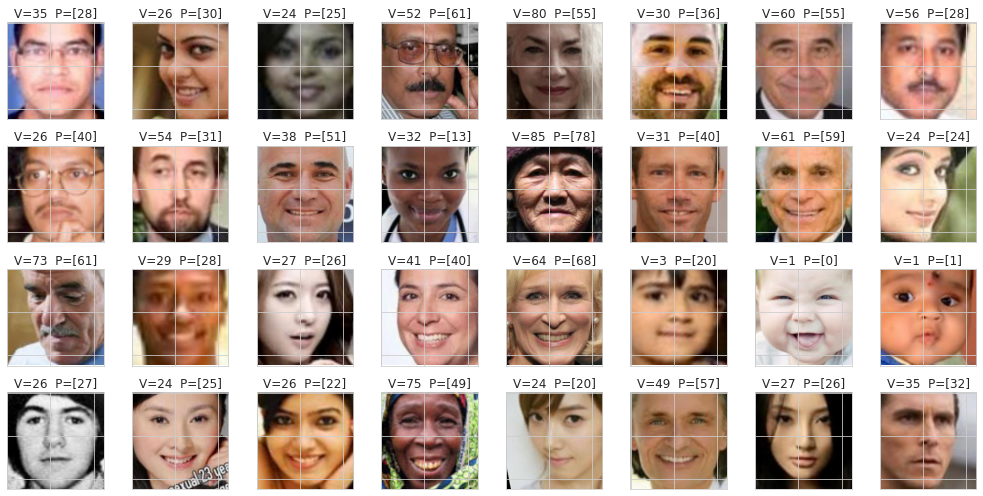

In [27]:
with torch.no_grad():
    x, y_true = next(iter(tst_dl))
    y_pred = model2(x.to(device))
    display_batch(ROWS, COLS, x.cpu(), y_true, y_pred.cpu())